# 0. Configuration et Chargement des Bibliothèques


## Import des bibliothèques

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
from sklearn.utils.class_weight import compute_class_weight

## Chemins des données

In [3]:
data_dir_train = 'fer2013/train'
data_dir_test = 'fer2013/test'

# 1. Exploration des données

In [4]:
# Liste des classes (émotions)
classes = sorted(os.listdir(data_dir_train))
print(f"Classes disponibles : {classes}")

Classes disponibles : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# Vérifier le nombre d’images par classe
train_counts = {cls: len(os.listdir(os.path.join(data_dir_train, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(data_dir_test, cls))) for cls in classes}

print("Nombre d'images par classe (train) :", train_counts)
print("Nombre d'images par classe (test) :", test_counts)

Nombre d'images par classe (train) : {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Nombre d'images par classe (test) : {'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


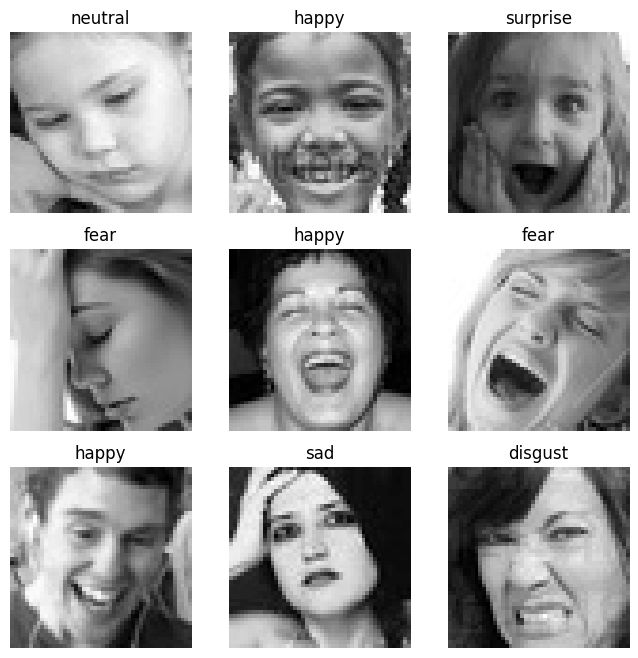

In [6]:
# Visualisation de Quelques Images
def plot_sample_images(data_dir, num_images=9):
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        class_name = np.random.choice(classes)  # Choisir une classe aléatoire
        class_path = os.path.join(data_dir, class_name)
        img_name = np.random.choice(os.listdir(class_path))  # Choisir une image aléatoire
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")

    plt.show()

# Affichage des images du dataset
plot_sample_images(data_dir_train)

In [7]:
# Vérification de la Taille des Images
img_path = os.path.join(data_dir_train, classes[0], os.listdir(os.path.join(data_dir_train, classes[0]))[0])
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(f"Taille d'une image : {img.shape}")

Taille d'une image : (48, 48)


# 2. Préparation des Données

## 2.1. Prétraitement des données

In [8]:
img_size = (48, 48)

# Normalisation et Augmentation de données pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% des données pour la validation
)

# Normalisation seule pour l'ensemble de test
test_datagen = ImageDataGenerator(rescale=1.0/255)

## 2.1. Séparation en Entraînement / Validation / Test

In [9]:
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=img_size,
    batch_size=32,  
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=img_size,
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=img_size,
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
# Affichage des classes détectées
class_labels = list(train_generator.class_indices.keys())
print("Classes détectées :", class_labels)

Classes détectées : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# 3. Augmentation des Données

## 3.1. Techniques d'augmentation

Found 28709 images belonging to 7 classes.


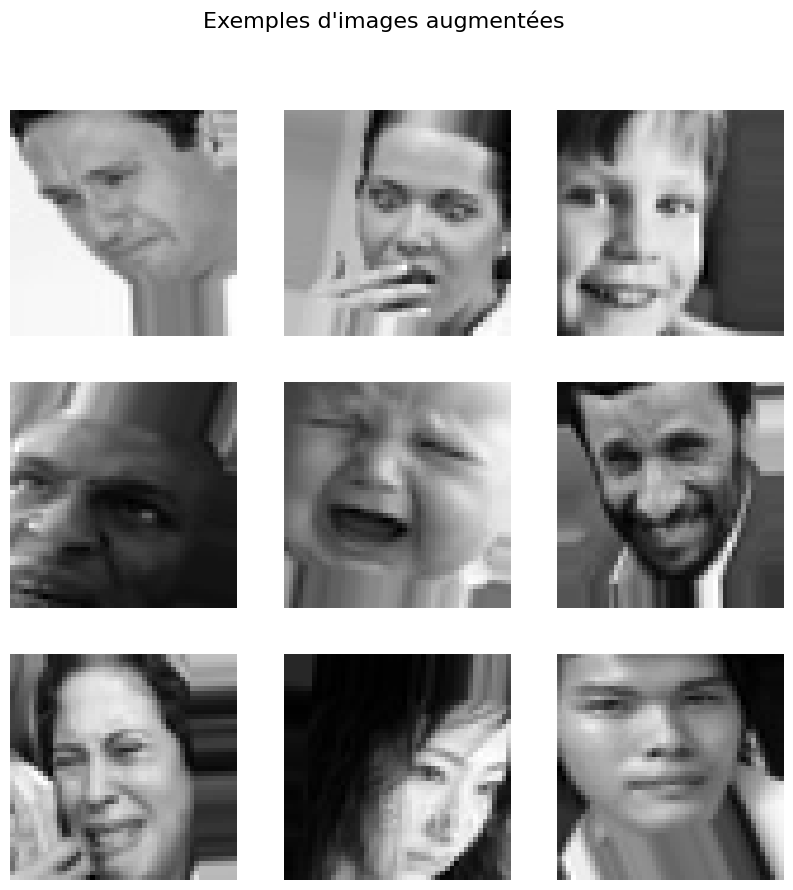

In [11]:
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

augmented_generator = augmented_datagen.flow_from_directory(
    data_dir_train,
    target_size=img_size,
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)

# Visualisation d'images augmentées
augmented_images, _ = next(augmented_generator)
plt.figure(figsize=(10, 10))
plt.suptitle("Exemples d'images augmentées", fontsize=16)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## 3.2. Balancing des classes


In [12]:
# Calcul des poids des classes pour équilibrer les classes
y_train = train_generator.classes  # Labels des classes dans l'ensemble d'entraînement
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print("Poids des classes :", class_weights_dict)

Poids des classes : {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [ ]:
# Étape 5 : Construction du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
# Étape 6 : Définition des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Étape 7 : Entraînement du modèle
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    callbacks=[early_stopping]
)

In [ ]:
# Étape 8 : Visualisation des performances
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Précision au cours des époques')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Erreur au cours des époques')
plt.xlabel('Époques')
plt.ylabel('Erreur')
plt.legend()

plt.show()

In [ ]:
# Étape 9 : Évaluation sur les données de test
loss, accuracy = model.evaluate(test_data)
print(f"\nÉvaluation finale :\n - Précision : {accuracy*100:.2f}%\n - Perte : {loss:.4f}")

In [ ]:
# Étape 10 : Matrice de confusion et visualisation des prédictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_data.class_indices.keys())

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues', xticks_rotation='vertical', ax=plt.gca())
plt.title('Matrice de confusion')
plt.show()

In [ ]:
# Visualisation d'images avec prédictions et étiquettes réelles
def plot_predictions(test_data, y_pred_classes, n_images=9):
    """Affiche des images avec leurs étiquettes prédites et réelles."""
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Prédictions vs Réalité', fontsize=16)

    images, labels = next(test_data)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        true_label = labels[i].argmax()
        predicted_label = y_pred_classes[i]
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(f"Réel: {labels[true_label]}\nPrédit: {labels[predicted_label]}", color=color)
        ax.axis('off')
    plt.show()

plot_predictions(test_data, y_pred_classes)

In [ ]:
# Étape 11 : Déploiement avec Gradio
import Gradio as gr
def emotion_recognition(image):
    """Prend une image en entrée, détecte les visages et prédit les émotions."""
    # Conversion en niveaux de gris et redimensionnement
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Gradio fournit des images au format RGB
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(48, 48))

    results = []
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48)) / 255.0
        face = np.expand_dims(face, axis=-1)
        face = np.expand_dims(face, axis=0)
        prediction = model.predict(face)
        emotion_label = labels[np.argmax(prediction)]
        results.append((emotion_label, (x, y, w, h)))

    for emotion_label, (x, y, w, h) in results:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image

iface = gr.Interface(
    fn=emotion_recognition,
    inputs=gr.Image(type="numpy"),  # Gradio utilise le format numpy pour les images
    outputs=gr.Image(type="numpy"),
    title="Détection d'Émotions avec CNN",
    description="Chargez une image pour détecter les émotions des visages présents."
)

iface.launch()
